In [943]:
import re
import emoji
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from transformers import pipeline
import nltk

In [944]:
rcParams['figure.figsize'] = (15, 10)
sns.set(font_scale=1.5)

In [945]:
com_df = pd.read_csv('../data/comments_info.csv')
tweet_df = pd.read_csv('../data/tweets_info.csv')

cols_to_datetime = ['tweet_created', 'account_created']
df = pd.concat([tweet_df, com_df], axis=0, ignore_index=True)

### Text Exploration

In [946]:
df.head()

,tweet_created,conversation_id,tweet_id,author_id,text,retweet_count,reply_count,like_count,quote_count,account_created,account_id,name,verified,follower_count,following_count,tweet_count,listed_count
0,2022-06-09T23:23:33.000Z,1535039928752537618,1535039928752537618,361289499,"There's less than 100,000 blocks until the nex...",423,247,2652,13,2011-08-24T15:14:54.000Z,361289499,Bitcoin Magazine,True,2507182,757,23373,13757
1,2022-06-09T22:18:54.000Z,1534926244369817601,1535023660301398016,361289499,Looking for #Bitcoin gear? We've got you cover...,30,34,133,2,2011-08-24T15:14:54.000Z,361289499,Bitcoin Magazine,True,2507182,757,23373,13757
2,2022-06-09T21:04:36.000Z,1534953242878259202,1535004962417037312,361289499,Stay up to date on the latest #Bitcoin news wi...,26,28,86,1,2011-08-24T15:14:54.000Z,361289499,Bitcoin Magazine,True,2507182,757,23373,13757
3,2022-06-09T20:28:23.000Z,1534995848278466565,1534995848278466565,361289499,"RT @mcshane_writes: In mathematics, the pigeon...",47,0,0,0,2011-08-24T15:14:54.000Z,361289499,Bitcoin Magazine,True,2507182,757,23373,13757
4,2022-06-09T20:16:55.000Z,1534992962425192448,1534992962425192448,361289499,RT @BitcoinMagazine: @saylor @MicroStrategy Th...,44,0,0,0,2011-08-24T15:14:54.000Z,361289499,Bitcoin Magazine,True,2507182,757,23373,13757


In [947]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33673 entries, 0 to 33672
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_created    33673 non-null  object
 1   conversation_id  33673 non-null  int64 
 2   tweet_id         33673 non-null  int64 
 3   author_id        33673 non-null  int64 
 4   text             33673 non-null  object
 5   retweet_count    33673 non-null  int64 
 6   reply_count      33673 non-null  int64 
 7   like_count       33673 non-null  int64 
 8   quote_count      33673 non-null  int64 
 9   account_created  33673 non-null  object
 10  account_id       33673 non-null  int64 
 11  name             33672 non-null  object
 12  verified         33673 non-null  bool  
 13  follower_count   33673 non-null  int64 
 14  following_count  33673 non-null  int64 
 15  tweet_count      33673 non-null  int64 
 16  listed_count     33673 non-null  int64 
dtypes: bool(1), int64(12), object(4

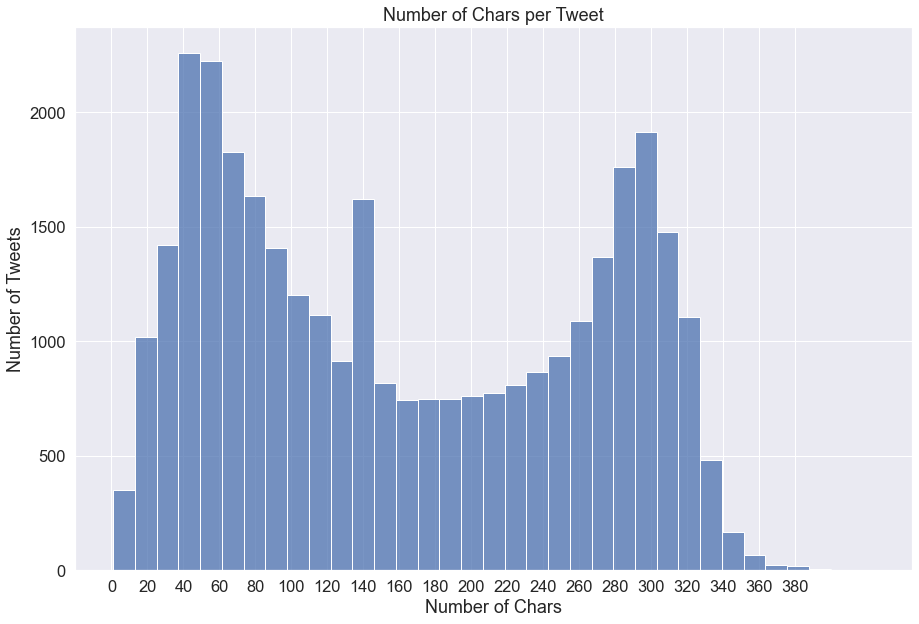

In [948]:
# let's look at the number of characters per tweet
sns.histplot(df['text'].str.len())
plt.xticks(list(range(0, 400, 20)))
plt.xlabel('Number of Chars')
plt.ylabel('Number of Tweets')
plt.title('Number of Chars per Tweet');

###### Twitter allows max 280 characters per tweets, so all the tweets with more than 280 char must contain either a lot of mentions (@someone) or links. We can also observe large amount of tweets with low number of chars. This might be caused either by stopwords, slang or something else, they might not hold a lot of meaning.
##### TODO
1. Remove Mentions (e.g. @coinbase)
2. Remove leading RT (stands for retweeted)
3. Remove leading hashtag sign
4. Remove spaces etc
5. Check the tweets with low number of chars.

In [949]:
# let's look at the actual test and see what makes tweets surpass 280 mark
df[df['text'].str.len() > 320].text.values[1]

"@IndiraKempis @senadomexicano Subscribe to Bitcoin Magazine's FREE daily newsletter and get the latest news delivered right to your inbox!\n\nToday's edition covered:\n🏡 Home mining experts talk strategy\n🏛️ Fort Worth, TX vote on bitcoin mining bill\n🐒 Costa Rica's bitcoin jungle\n\n👇📰\nhttps://t.co/XpRwZUa1it https://t.co/VTpKm1LcaY"

In [950]:
# let's remove mentions, so we can see the actual text of the tweet, and look at the graph again
df['text'].replace(r"@[^\s]+", '', regex=True, inplace=True)  # removing mentions @
df['text'].replace(r'RT ', '', regex=True, inplace=True) # removing RT (retweeted)
df['text'].replace(r'#', '', regex=True, inplace=True)  # remove hashtags
df['text'].replace(r'http\S+', '', regex=True, inplace=True)  # removing links
df['text'].replace(r'&[A-Za-z0-9#]+;', '', regex=True, inplace=True) # removing html character reference
df['text'].replace(r"\s+", " ", regex=True, inplace=True) # remove extra space, new lines ...
df.loc[:, 'text'] = df['text'].apply(lambda row: row.strip())
# df['text'].replace(r'\u200d', '', regex=True, inplace=True) # catching \u200d (width joiner) used for emojis

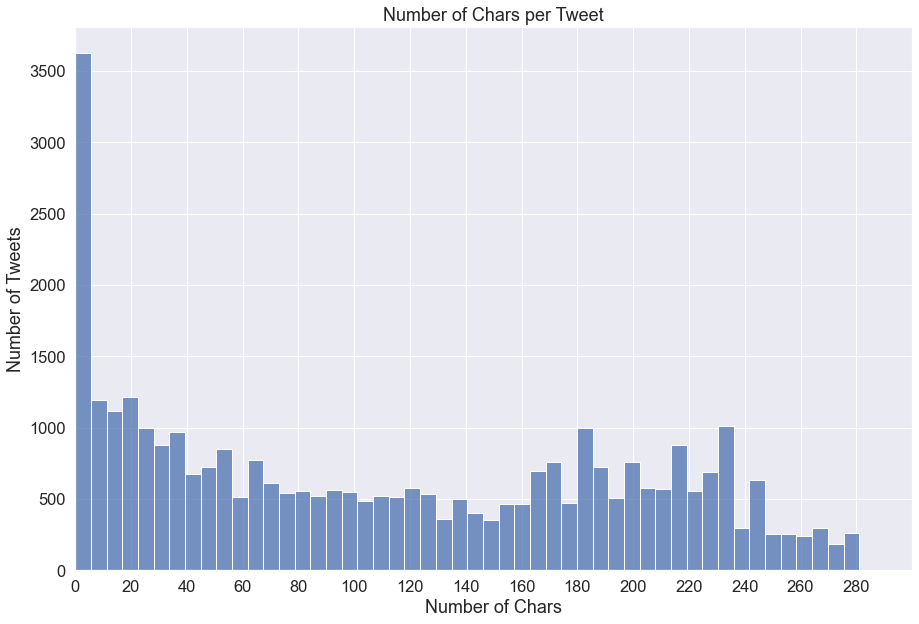

In [951]:
sns.histplot(df['text'].str.len(), bins=50)
plt.xticks(list(range(0, 290, 20)))
plt.xlim(0, 300)
plt.xlabel('Number of Chars')
plt.ylabel('Number of Tweets')
plt.title('Number of Chars per Tweet');

###### Now we see that all the tweets fall within the limit of 280 chars, but the number of tweets with less than 20 chars has increased drastically.

In [952]:
# lets see what we can fit in within 20 chars
sample_text = 'Market is going to crash'
print(f'Length of this text "{sample_text}" is {len(sample_text)} chars.')

Length of this text "Market is going to crash" is 24 chars.


###### I would think that tweets that have less than 15-20 chars are meaningless. Let's explore what kind of tweets have a few characters

In [953]:
# first let's check if we have empty strings and get rid of them
print('Number of empty string',len(df[df['text'].isin(['', ' '])].text))
df = df[~df['text'].isin(['', ' '])]

Number of empty string 2017


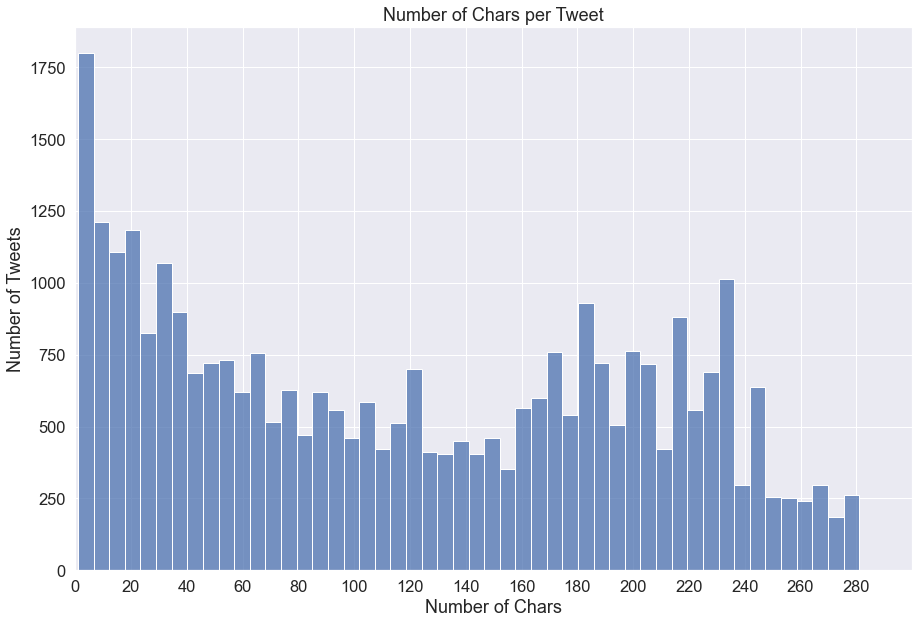

In [954]:
sns.histplot(df['text'].str.len(), bins=50)
plt.xticks(list(range(0, 290, 20)))
plt.xlim(0, 300)
plt.xlabel('Number of Chars')
plt.ylabel('Number of Tweets')
plt.title('Number of Chars per Tweet');

###### Great, we cut the number of tweets with less than 20 by a third. Although, we have to keep in mind that a lot of tweets that we get are empty, and we might have to extract more information. Let's continue to explore tweets with low number of words.

In [955]:
df[df.text.str.len() < 20].text.value_counts().head(40)

gm                     143
Gm                     103
Thank me later         102
👇                       74
👀                       34
😂                       30
Join the chat💬👇         23
❤️                      22
GM                      22
Bitcoin $paw            18
Gm ser                  16
Web 3                   16
Worth reading $paw      16
TRX TRON USDD           16
Join 💬chat to earn      16
😂😂😂                     15
Gm!                     14
Gm gm                   14
Bitcoin                 14
Good                    12
🚀Airdrop campaign 👉     10
🤣🤣🤣                     10
Limited time offer!     10
$PAW                     9
TRV Blockchain           9
lol                      9
BRISE x 2000             9
gm!                      9
New eps. Tune in 🫶🏼      9
BTC                      9
Lol                      9
Yes                      9
Awesome                  8
👍                        8
Nice                     8
🔥🔥🔥                      8
🤌🏻                       8
G

###### We can observe that greeting (gm) is quite common in bitcoin community, but to us, it does not hold much value, so let's get rid of it. As well as 'Thank me later'

In [956]:
print(f"gm/thank me later like occurrences: {df[(df.text.str.contains(r'gm|Gm|GM|Thank me later', regex=True)) & (df.text.str.len() < 20)].__len__()}")
df = df[~((df.text.str.contains(r'gm|Gm|GM|Thank me later', regex=True)) & (df.text.str.len() < 20))]

gm/thank me later like occurrences: 808


In [957]:
print(f'# commments < 20 chars {df[df.text.str.len() < 20].text.shape}')
print(f'total comments {df.text.shape}')
df[df.text.str.len() < 20].text.value_counts().head()

# commments < 20 chars (3752,)
total comments (30848,)


👇                  74
👀                  34
😂                  30
Join the chat💬👇    23
❤️                 22
Name: text, dtype: int64

###### We see that we still have over 3k comments shorter than 20 chars, which makes it roughly 100 comments per 1000 comments or every 10th
##### TODO
1. Convert emojis to text
2.  Get rid of spam comments
3. Think how to assign meaning to one word emotions
4. We yet have not dealt with special characters

In [958]:
# let's convert emojis to words

In [959]:
# let's look at all the tweets that have emojis
emoji_df = df[df.text.str.contains(r'|'.join(map(re.escape, list(emoji.EMOJI_DATA.keys()))), regex=True)]

In [960]:
emoji_df.text.head()

0     There's less than 100,000 blocks until the nex...
1     Looking for Bitcoin gear? We've got you covere...
2     Stay up to date on the latest Bitcoin news wit...
5     El Salvador approved the Bitcoin Law one year ...
10    Missing your Bitcoin friends and high signal B...
Name: text, dtype: object

In [961]:
# let's demojize these tweets and see what is does
demojized_df = emoji_df.copy(deep=True)
demojized_df.loc[:, 'text'] = demojized_df.text.apply(lambda row: emoji.demojize(row))

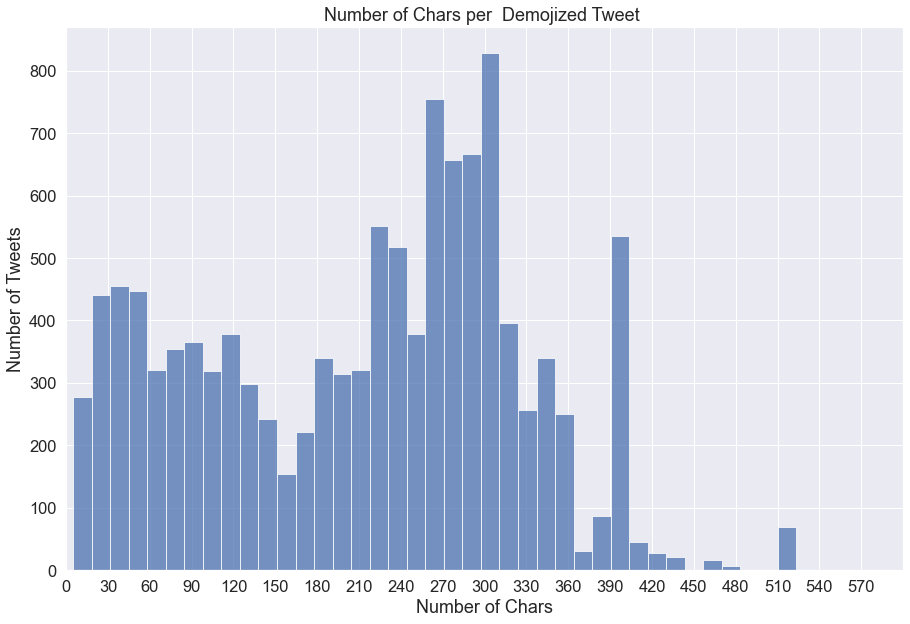

In [962]:
sns.histplot(demojized_df.text.str.len(), bins=100)
plt.xlim(0, 600)
plt.xticks(list(range(0, 600, 30)))
plt.xlabel('Number of Chars')
plt.ylabel('Number of Tweets')
plt.title('Number of Chars per  Demojized Tweet ');

###### We can see how it increases number of chars per tweet, lets take a closer look at the outliers

In [963]:
# let's take a look at the tweets that exceed 300 chars (we will give a buffer of 20 chars)
emoji_outliers = demojized_df[demojized_df.text.str.len() > 300].text.map(lambda row: emoji.emojize(row))
emoji_outliers.value_counts().head(10)

🪐 WELCOME TO BEERUSX100 🔥 ✅ KYC Audit ✅ No team tokens ✅ Liquidity will be locked after listing ✅ Ownership will be renounced ✅ Lowcap presale ✅ Tax 4% (buy/sell) 👉 Contract: 👉 ILO : 🌎                                                               503
🚨IDO ALERT🚨 is pleased to announce the IDO of on the 15th of June at 12 PM UTC! All you need to know about is; 💎 Total tokens for sale: 600,000 EMT 💰 Total Raise: 1,200,000$ 💵 IDO Price: 0.05$ 🚀 Initial MC at TGE: 217,000$ BNB crypto              448
💎 Introducing Bit-Luna 0.5 token, the heir to the Luna fortune - Join us for 1000x gains 💰Total Supply: 10,000,000,000 💊 9% BUY / 15% SELL TAX 💊 SAFU: LIQUIDITY LOCKED 100% 💊 AUDIT + KYC 💊 WHITEPAPER 💊 VERIFIED CONTRACT 💊 RARE NFTS 📌 Telegram:    116
✅ World First USE -2- EARN Ecosystem. ✅ 🚀 Alpha App Live 📲 No Private Sale 📲 Contract Verified 📲 Audit By ContractWolf 📲 KYC'd By Doxxed 📲 Partnership With Coinhunt,NABOX, IKONIC, parrot bamboo                                                      

In [964]:
df.text.value_counts().head(10)

🪐 WELCOME TO BEERUSX100 🔥 ✅ KYC Audit ✅ No team tokens ✅ Liquidity will be locked after listing ✅ Ownership will be renounced ✅ Lowcap presale ✅ Tax 4% (buy/sell) 👉 Contract: 👉 ILO : 🌎                                                                                      503
🚨IDO ALERT🚨 is pleased to announce the IDO of on the 15th of June at 12 PM UTC! All you need to know about is; 💎 Total tokens for sale: 600,000 EMT 💰 Total Raise: 1,200,000$ 💵 IDO Price: 0.05$ 🚀 Initial MC at TGE: 217,000$ BNB crypto                                     448
📌🔥 CRYPTO ASSISTANT 🔥 Crypto Assistant is a platform where you can find all crypto token information in one place,clearly arranged in one agenda... Web: TG: 🟢8% buy sell tax 🟢LP locked 🟢Kyced Audited 🟢presale: 6/17/2022                                                   288
🐕 $DOGGER 🐕 Dogger aims to be the first decentralized and open source social media platform for the crypto world ☑️ A greatly improved contract ☑️ Huge staking rewards ☑️ Reduced


###### Wow, if we compare duplicates in main dataframe and dataframe with emojis that have too many characters, we can see that the top duplicates are identical. This signifies that most of the spam comments will be using extensive amount emojis. We should be getting rid of the extensive number of duplicate comments from the main df  (maybe over ~20 duplicates) in the beginning of preprocessing to speed up the process.
##### We should try different clipping thresholds, I think a good point to start is 20 duplicates, however we need to keep in mind that spam comments might influence human behaviour.

In [965]:
df.text.value_counts().describe()

count    20315.000000
mean         1.518484
std          6.308648
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        503.000000
Name: text, dtype: float64

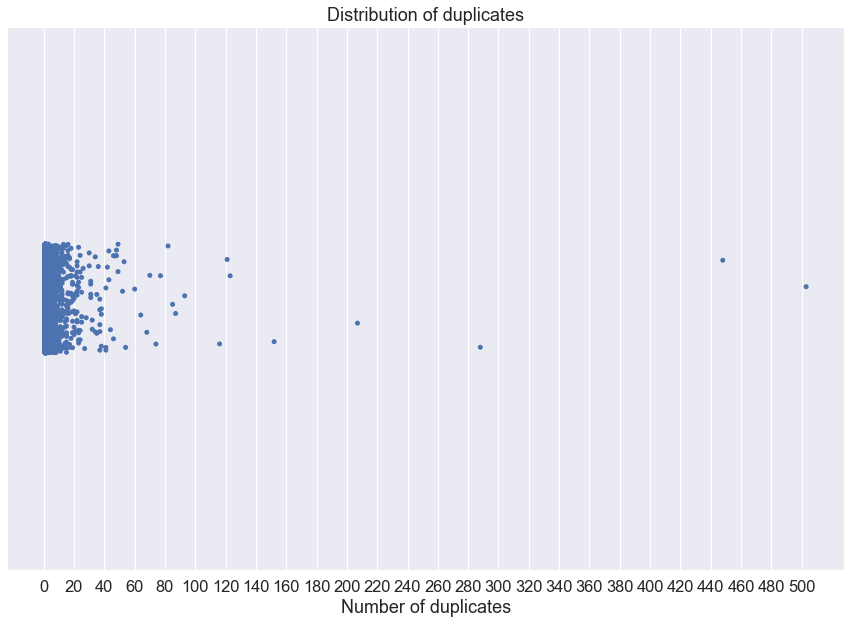

In [966]:
# let's visualize distribution of the duplicate tweets
sns.stripplot(x=df.text.value_counts().to_numpy(), )
plt.title('Distribution of duplicates')
plt.xticks(list(range(0, 520, 20)))
plt.xlabel('Number of duplicates');

In [967]:
# let's read some tweets
df.text.value_counts().reset_index(name='counts').loc[1040: 1055, :]

,index,counts
1040,As usual doing things differently for it's Sea...,2
1041,"Hey, please DM me 📩 for Collaboration",2
1042,Join us at Capital Group Exchange™️ (No need t...,2
1043,1-Bitcoin was the beginning of the cryptocurre...,2
1044,The yield farming “Magic Box” model and crypto...,2
1045,I buy some $lzn and keeps make me profit every...,2
1046,"We just launched, is ready to break the silenc...",2
1047,Support American Cancer Society through my pag...,2
1048,Do u know about look at this at global group K...,2
1049,✅BUTCH INU 25k MC$ ✅TG ✅Ca: 0xc61e14952e6ff7b7...,2


###### We can see that even when there are only two duplicates, a majority of them are still spam comments. So we definitely should start with the threshold of 2 duplicates instead of 20 lol

In [968]:
# keeping only tweets that repeat no more than twice
df = df[~df['text'].isin(df['text'].value_counts().loc[lambda cnt: cnt > 2].index)]

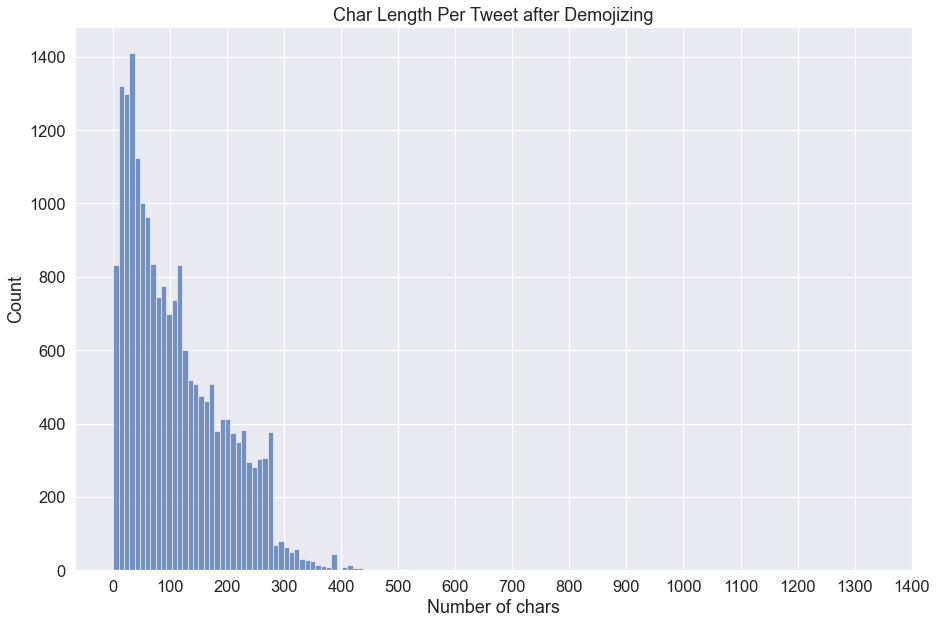

In [969]:
# now we can convert emoji to text
demojized_df = df.text.apply(lambda row: emoji.demojize(row))
sns.histplot(demojized_df.str.len())
plt.xticks(list(range(0, 1500, 100)))
plt.title('Char Length Per Tweet after Demojizing')
plt.xlabel('Number of chars');

###### we keep observing outliers after demojizing tweets, let's look into those outliers.

In [970]:
df[demojized_df.str.len().sort_values(ascending=False) > 280].text.sample(10)

/var/folders/7g/cgf84kh50nz2xnzmyw4qqrj40000gn/T/ipykernel_54990/2082101554.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[demojized_df.str.len().sort_values(ascending=False) > 280].text.sample(10)


4784     go sign up on get some dudes peoples money hel...
22638    ⛱ Airdrops$ 5000 usdt PhantomChain At Ratings:...
23061    🚀🚀🚀Saturday 11th🚀🚀🚀 💥💥💥💥public presale💥💥💥💥 👇👇G...
72       Subscribe to our FREE daily newsletter and get...
10275    started with $2,000 now I am making $20,780 ev...
995      Sign up for a FREE 30 Day Trial of Bitcoin Mag...
30994    Hello 👋 is a stable token 📊with a great projec...
453      New to Bitcoin? Enroll in our FREE 21 Days of ...
20940    Yeah mate, you lost this discussion. As soon a...
12533    All of my friends!!!💥💥💯 The AEX exchange has l...
Name: text, dtype: object

###### we can see that even though 1-2 comments are genuine, the majority of them are spam as well. So that will be our second spam check. We will have to convert emoji to text first in this case.

In [971]:
df.loc[:, 'text'] = df.text.apply(lambda row: emoji.demojize(row))

In [972]:
# now we will get rid of the tweets with more than 280 chars because there is a high chance of them being spam
df = df[df.text.str.len() < 280]

In [976]:
df[df.text.str.len() > 275].text.apply(lambda row: emoji.emojize(row)).sample(10)

6814     It's very clear: the rich are trying to keep t...
29610    We are Professional Traders Portfolio Managers...
7465     Do you think the states will accept Bitcoin fo...
8372     He doesn’t understand hard asset, or money. So...
21106    You are right, I meant in general for cryptos....
30382    Simple exchange of BlueBit to buy/sell BlueSpa...
5417     Sorry what is bitcoin actually innovating? Not...
7937     NELORECOIN Income generation with the fattenin...
4161     Why are gas prices so high? Massive underinves...
28397    PrimeVerse PRIM Liquidity Locked for 1 year.🛡️...
Name: text, dtype: object

###### Now if we look at some samples with the highest number of chars, most of the tweets are genuine, though some of the spams still persist

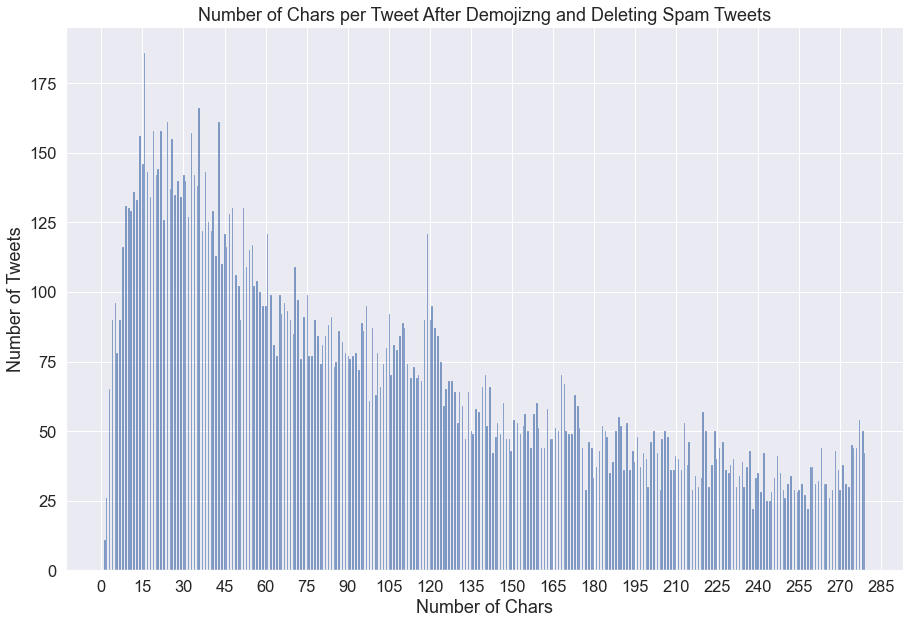

In [987]:
sns.histplot(df['text'].str.len(), bins=500)
plt.xticks(list(range(0, 290, 15)))
plt.xlabel('Number of Chars')
plt.ylabel('Number of Tweets')
plt.title('Number of Chars per Tweet After Demojizng and Deleting Spam Tweets');

###### It looks like we were able to deal with some problematic long tweets, but we have not achieved as mush success with short tweets. Let's take a closer look with what kind of text we are working with.

In [1018]:
short_tweets = df.loc[df[df.text.str.len() < 20].text.str.len().sort_values().index, 'text']
print(f'Length of short_tweets {len(short_tweets)}')
print(short_tweets.tolist())

Length of short_tweets 2154
['5', 'G', '*', 'Y', '!', '2', 'S', 'ใ', '1', '？', 'K', 'Hi', 'gn', 'cc', '1%', ':/', 'mg', 'mg', 'So', 'Yo', 'HI', 'Hi', '?!', 'BT', 'qq', '1$', 'Is', 'RN', 'ok', 'ew', '91', '….', 'Dm', '10', 'XD', 'A+', 'us', 'Yha', 'Cbd', ':))', 'Fji', 'YES', 'DKS', 'Hi.', 'DKS', 'Ooo', 'Hi!', 'Hmm', 'Big', 'g m', 'ADA', 'Ola', 'Bro', 'BIG', 'Fud', 'if*', '(,,', 'Nah', 'Who', 'How', 'XRP', 'RET', 'How', 'So?', 'YES', ': 0', 'FFS', 'ACN', 'nts', 'JFC', '去看看', 'TRV', 'GFY', 'Anc', 'btc', 'Mil', 'BIG', 'TR9', 'Bad', 'wen', 'WOW', '...', '??!', 'NYC', 'Huh', 'Ifb', '20k', 'Wtf', 'Art', '10k', 'wat', 'ADA', 'OMG', '*pr', 'omg', 'wow', 'Me.', 'Yep', 'LOL', 'Try', 'wow', 'LOL', 'THIS', 'haha', 'Sure', '18.5', 'Luna', 'Hmmm', '$ERR', 'mETH', 'Yes,', 'Scam', '$QRL', 'Haha', 'Dumb', 'join', 'Troy', 'Few.', 'Scam', 'why？', 'Few.', 'damn', 'Okay', 'Mom?', 'Wow,', 'Dang', '$amp', 'Damn', '2024', 'Why?', 'haha', '2062', 'Oops', 'n=36', '2023', 'Web3', 'Woof', 'rekt', 'Yass', 'Rly?', '

###### We can see that most of it is useless, but as the number of chars increases, we can derive some meaning. We have the following options.
1. Remove tweets which have less than n number of chars, where n is ~ 20
2. Do a lot of regex to try match most common patterns and get rid of them
3. Extract only adjectives using nltk library, get rid of the rest. Without context many single adjectives might skew our average sentiment. Therefore, we can prepend the original tweet to the adjective. That way, our model will have more context and an emotion/reaction about it in the end. It could be a good guidance for classifying ambiguous original tweets.
4. Lastly, when averaging our sentiments, we can assign lower weights to comments with low number of characters.

In [506]:
# Let's see how not tuned sentiment classifier classifies some of the text
# positive = 'should be positive'
# negative = 'should be negative'
#
# print(pipeline('sentiment-analysis')('Bitcoin is the lifeboat.'), positive)
# print(pipeline('sentiment-analysis')('#BTC'), positive)
# print(pipeline('sentiment-analysis')('BTC'), positive)
# print(pipeline('sentiment-analysis')('#Bitcoin'), positive)
# print(pipeline('sentiment-analysis')('Bitcoin'), positive)
# print()
# print(pipeline('sentiment-analysis')('🚀'), positive)
# print(pipeline('sentiment-analysis')('🤑✨🤑✨🤑✨🤑'), positive)
# print()
# print(pipeline('sentiment-analysis')('sTaBlEcOiN'), negative)
# print(pipeline('sentiment-analysis')('🤡'), negative)
# we can see that our not tuned classifier did horrible. Some things to note is that #BTC => neg while BTC => pos, so we should get rid of the leading pound sign before the hashtags; transform emojis to text

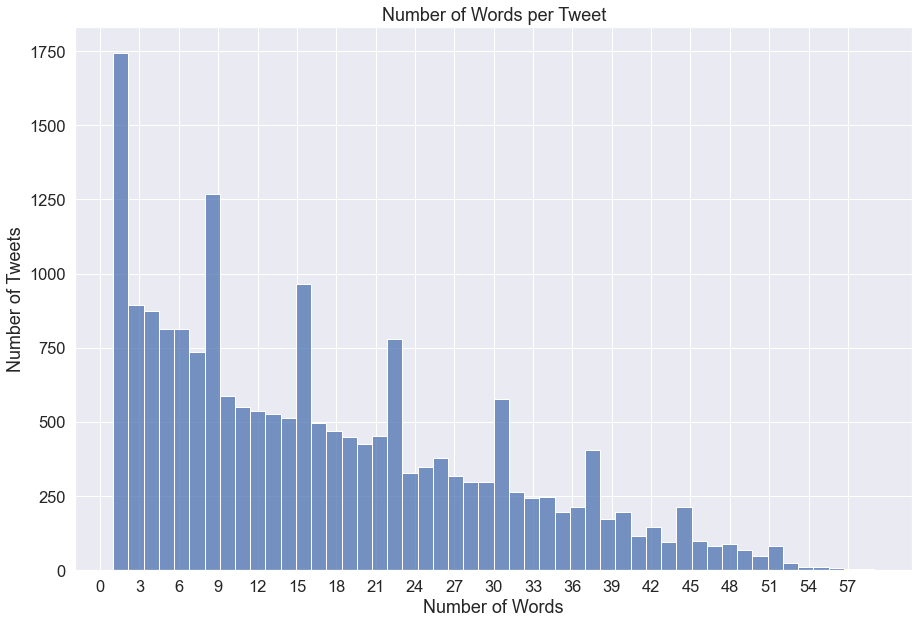

In [1019]:
# let's look at the number of words per tweet
sns.histplot(df.text.str.split().map(lambda words: len(words)), bins=50)
plt.xticks(list(range(0, 60, 3)))
plt.xlabel('Number of Words')
plt.ylabel('Number of Tweets')
plt.title('Number of Words per Tweet');

###### Once again we can observe high number of tweets with low word count.

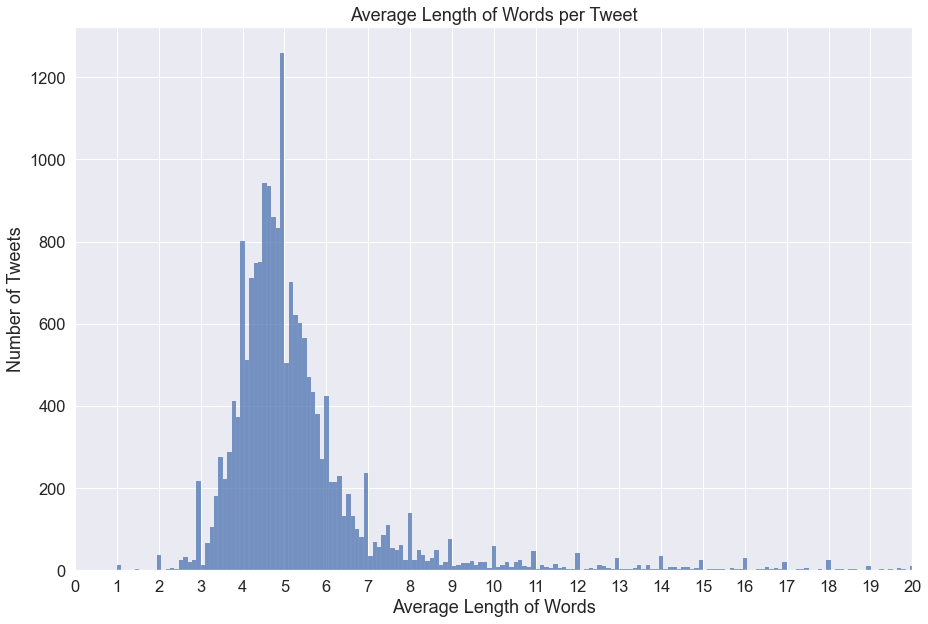

In [1020]:
# let's check what is the average word length per tweet
sns.histplot(df.text.str.split().map(lambda words: sum(len(word) for word in words)/len(words)))
plt.xticks(list(range(0, 30, 1)))
plt.xlim(0, 20)
plt.xlabel('Average Length of Words')
plt.ylabel('Number of Tweets')
plt.title('Average Length of Words per Tweet');

###### We can observe that average length of the words per tweet is around 6 chars, which I think is normal. However, we do have some extreme outliers on the right that we should look into. Big number of mentions is probably what is causing such behaviour.